In [86]:
import json
import matplotlib.pyplot as plt
import os

In [188]:
def get_data_from_stats_json (filename):
    """
        Takes a .json file, gets from the json-objects in it certain interesting values 
        and processes them for further analysis. 
    """
    with open (filename, 'r') as file:
        data = json.load(file)

    container_output = data.get("containerOutput")
    tcp_percentage = data.get("tcpPercentage")
    cpu_nano = [out.get("Stats")[0].get("CPUNano") for out in container_output]
    cpu_system_nano = [out.get("Stats")[0].get("CPUSystemNano") for out in container_output]
    cpu_nano_diffs = [(cpu_nano[i] - cpu_nano[i-1])/1e9 for i in range(1, len(cpu_nano))]
    cpu_system_nano_diffs = [(cpu_system_nano[i] - cpu_system_nano[i-1])/1e9 for i in range(1, len(cpu_system_nano))]
    cpu_percentage = [100 * cpu/30 for cpu in cpu_nano_diffs]
    initial_time = 0
    timing = [initial_time + i * 30 for i in range(len(cpu_nano_diffs))]
    sending_time = data.get("querySendingTime")
    number_queries = data.get("numberOfQueries" )
    network = data.get("network")

    return {
        "container_output" : container_output, 
        "tcp_percentage" : tcp_percentage, 
        "sending_time" : sending_time, 
        "number_queries" : number_queries, 
        "network" : network, 
        "cpu_nano_diffs" : cpu_nano_diffs, 
        "cpu_system_nano_diffs": cpu_system_nano_diffs,
        "cpu_percentage" : cpu_percentage, 
        "timing" : timing
    }



In [189]:
def make_a_plot(lines, x_axis_label, y_axis_label, title):
    """
        Takes lines and plots them with on the x-axis and y-axis the given label
        and having the given title.
    """
    for (x_data, y_data, data_label) in lines:
        if data_label is not None:
            plt.plot(x_data, y_data, label=data_label)
        else:
            plt.plot(x_data, y_data)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.savefig('graphs/' + title+'.pdf', bbox_inches="tight")
    plt.figure(dpi=1200) 
    plt.show()

# Automated analysis results
*Focusing on the CPU usage*

In [190]:
def make_list_of_outputs(directory):
    """
        Take all files that are in directory `directory`, parse 
        the json stored in each file and add then to the right 
        dictionary list, corresponding to the TCP percentage
    """
    files = os.listdir(directory)
    parsed_0 = []
    parsed_10 = []
    parsed_20 = []
    parsed_30 = []
    parsed_40 = []
    parsed_50 = []
    parsed_60 = []
    parsed_70 = []
    parsed_80 = []
    parsed_90 = []
    parsed_100 = []
    for filename in files:
        if not filename.endswith(".json"): # skip the files that are not json
            continue
        if filename.startswith("40"):
            continue
        parsed_output =  get_data_from_stats_json(directory + '/' + filename)
        percentage = filename.split('_')[0]
        parsed_output['tcp_percentage'] = percentage
        if percentage == '0':
            parsed_0.append(parsed_output)
        elif percentage == '10': 
            parsed_10.append(parsed_output)
        elif percentage == '20': 
            parsed_20.append(parsed_output)
        elif percentage == '30': 
            parsed_30.append(parsed_output)
        elif percentage == '40': 
            parsed_40.append(parsed_output)
        elif percentage == '50': 
            parsed_50.append(parsed_output)
        elif percentage == '60': 
            parsed_60.append(parsed_output)
        elif percentage == '70': 
            parsed_70.append(parsed_output)
        elif percentage == '80': 
            parsed_80.append(parsed_output)
        elif percentage == '90': 
            parsed_90.append(parsed_output)
        elif percentage == '100':
            parsed_100.append(parsed_output)
    return parsed_0, parsed_10, parsed_20, parsed_30, parsed_50, parsed_60, parsed_70, parsed_80, parsed_90, parsed_100

In [191]:
# Getting the average for a given output list
def average_parsed_output(output_list):
    """
        Given output_list (a list of dictionaries containing the json output file) we compute 
        the average over the different lists of the 'cpu_nano_diffs' and the 'cpu_system_nano_diffs'
        entries and return these
    """
    cpu_duration_to_average = [d['cpu_nano_diffs'] for d in output_list]
    if not all(len(cpu_duration_list) == len(cpu_duration_to_average[0]) for cpu_duration_list in cpu_duration_to_average):
        print("Not all of the lists in the cpu_duration_to_average list of lists are the same length.")
        print([len(cpu_dur_list) for cpu_dur_list in cpu_duration_to_average])
        print("TODO: this needs to be fixed")
        return None
    avg_cpu_duration = [sum(values)/len(values) for values in zip(*cpu_duration_to_average)]
    
    sys_cpu_duration_to_average = [d['cpu_system_nano_diffs'] for d in output_list]
    if not all(len(sys_cpu_duration_list) == len(sys_cpu_duration_to_average[0]) for sys_cpu_duration_list in sys_cpu_duration_to_average):
        print("Not all of the lists in the cpu_duration_to_average list of lists are the same length.")
        print(sys_cpu_duration_to_average)
        print("TODO: this needs to be fixed")
        return None
    avg_sys_cpu_duration = [sum(values)/len(values) for values in zip(*sys_cpu_duration_to_average)]

    cpu_percentage_to_average = [d['cpu_percentage'] for d in output_list]
    if not all(len(cpu_percentage) == len(cpu_percentage_to_average[0]) for cpu_percentage in cpu_percentage_to_average):
        print("Not all of the lists in the cpu_duration_to_average list of lists are the same length.")
        print(cpu_percentage_to_average)
        print("TODO: this needs to be fixed")
        return None
    avg_cpu_percentage = [sum(values)/len(values) for values in zip(*cpu_percentage_to_average)]
    
    return avg_cpu_duration, avg_sys_cpu_duration, avg_cpu_percentage

In [192]:
# ONLY FOR VERBOSE PLOTTING WITH ALL LINES PLOTTED 
def add_parsed_to_plotter(parsed, plotter_cpu, plotter_sys_cpu, plotter_percentage_cpu):
    """ 
        Takes the parsed dictionary and a list of plotting tuples and adds 
        the right information to the lists such that we can plot 
        the values in the dictionary
    """
    avg_cpu, avg_sys_cpu, avg_cpu_percentage = average_parsed_output(parsed)
    for i, output in enumerate(parsed):
        plotter_cpu.append((output['timing'], output['cpu_nano_diffs'], None))
        plotter_sys_cpu.append((output['timing'], output['cpu_system_nano_diffs'], None))
        plotter_percentage_cpu.append((output['timing'], output['cpu_percentage'], None))
    plotter_cpu.append((parsed[0]['timing'], avg_cpu, f"Avg for TCP {parsed[0]['tcp_percentage']}%"))
    plotter_sys_cpu.append((parsed[0]['timing'], avg_sys_cpu, f"Avg sys for TCP {parsed[0]['tcp_percentage']}%"))
    plotter_percentage_cpu.append((parsed[0]['timing'], avg_cpu_percentage, f"Avg percentage of CPU for TCP {parsed[0]['tcp_percentage']}%"))


In [193]:
# FOR ONLY PLOTTING THE AVERAGE 
def add_avg_parsed_to_plotter(parsed, plotter_cpu, plotter_sys_cpu, plotter_percentage_cpu):
    """
        Puts the average CPU usages from parsed on normal and on system level 
        into the right plotter arrays so that these can be plotted
    """
    avg_cpu, avg_sys_cpu, avg_cpu_percentage = average_parsed_output(parsed)
    plotter_cpu.append((parsed[0]['timing'], avg_cpu, f"Avg for TCP {parsed[0]['tcp_percentage']}%"))
    plotter_sys_cpu.append((parsed[0]['timing'], avg_sys_cpu, f"Avg sys for TCP {parsed[0]['tcp_percentage']}%"))
    plotter_percentage_cpu.append((parsed[0]['timing'], avg_cpu_percentage, f"Avg percentage of CPU for TCP {parsed[0]['tcp_percentage']}%"))


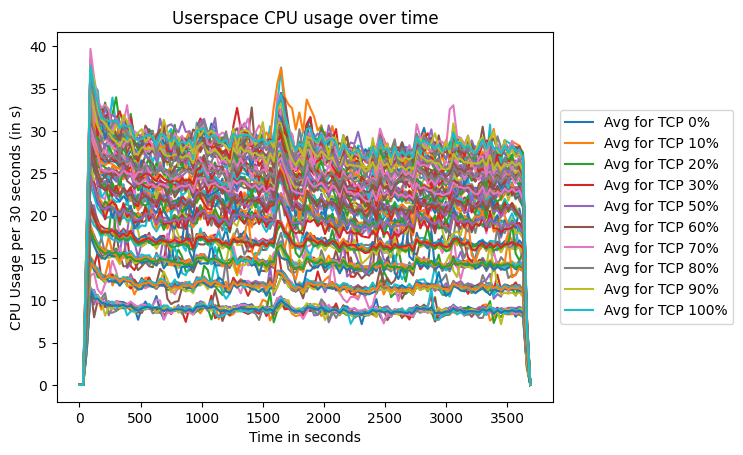

<Figure size 7680x5760 with 0 Axes>

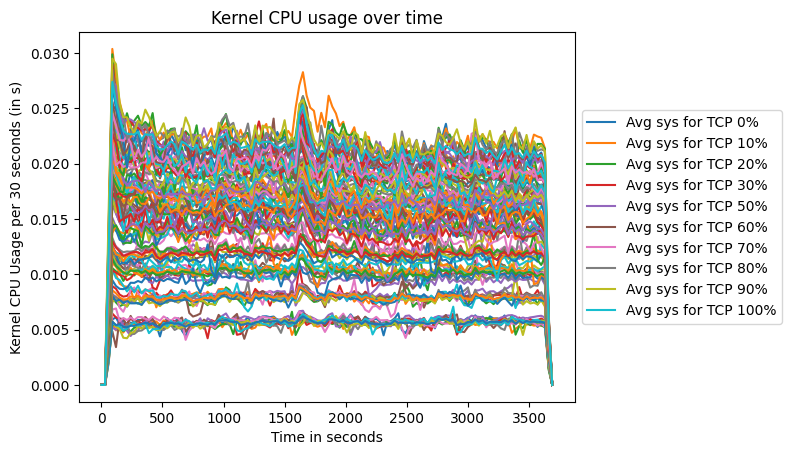

<Figure size 7680x5760 with 0 Axes>

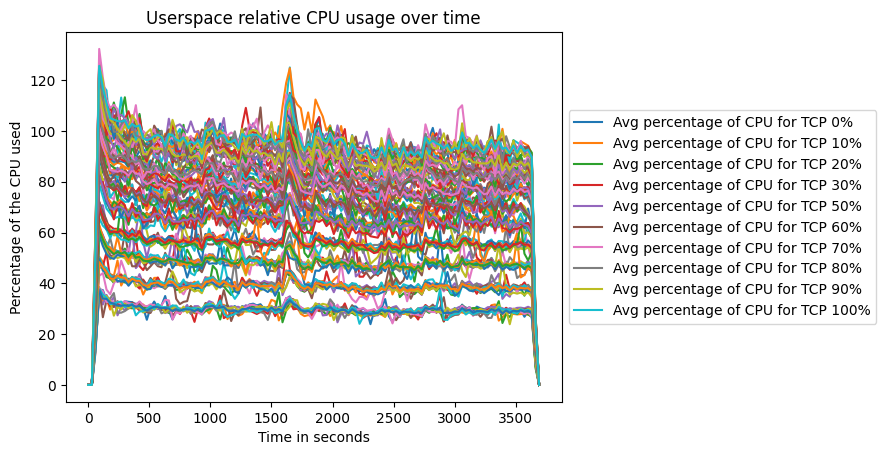

<Figure size 7680x5760 with 0 Axes>

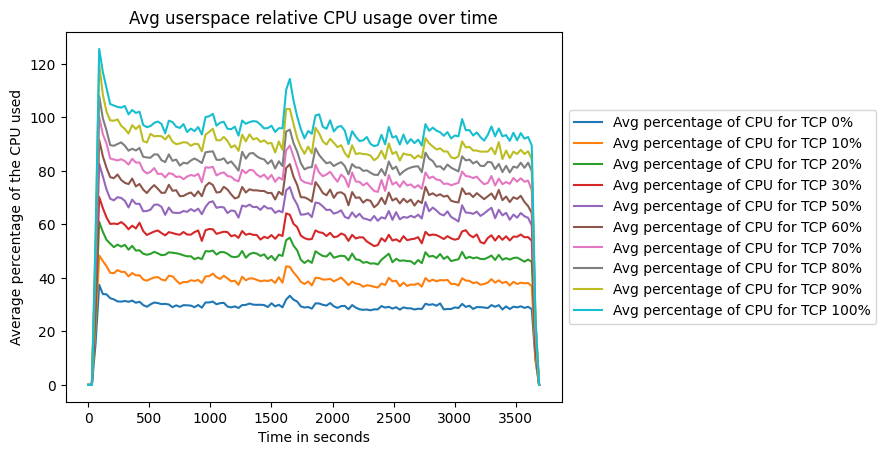

<Figure size 7680x5760 with 0 Axes>

In [195]:
parsed_outputs = make_list_of_outputs("stats-output/")

to_plot_cpu = []
to_plot_sys_cpu = []
to_plot_cpu_avg = []
to_plot_cpu_sys_avg = []
to_plot_percentage_cpu = []
to_plot_percentage_cpu_avg = []


for output in parsed_outputs:
    add_parsed_to_plotter(output, to_plot_cpu, to_plot_sys_cpu, to_plot_percentage_cpu)
    add_avg_parsed_to_plotter(output, to_plot_cpu_avg, to_plot_cpu_sys_avg, to_plot_percentage_cpu_avg)


make_a_plot(to_plot_cpu, "Time in seconds", "CPU Usage per 30 seconds (in s)", "Userspace CPU usage over time")
make_a_plot(to_plot_sys_cpu, "Time in seconds", "Kernel CPU Usage per 30 seconds (in s)", "Kernel CPU usage over time")
make_a_plot(to_plot_percentage_cpu, "Time in seconds", "Percentage of the CPU used", "Userspace relative CPU usage over time")
make_a_plot(to_plot_percentage_cpu_avg, "Time in seconds", "Average percentage of the CPU used", "Avg userspace relative CPU usage over time")


# TODO: redo measurement for deleted file 40_tcp_host_11-11-2025_16:53:11_5

# Plot only the average over time
This plot excludes the moments where the nameserver is not being queried

In [129]:
def calc_avg_over_time(parsed, avgs_cpu, avgs_sys_cpu):
    """
        Calculates the average parsed output from parsed, then calculates 
        over this the average energy consumption within the relevant time interval,
        adds this average value to the avg_cpu list
    """
    avg_cpu, avg_sys_cpu = average_parsed_output(parsed)
    avg_over_time = sum(avg_cpu[2:-2])/len(avg_cpu[2:-2])
    avg_sys_over_time = sum(avg_sys_cpu[2:-2])/len(avg_sys_cpu[2:-2])
    avgs_cpu.append(avg_over_time)
    avgs_sys_cpu.append(avg_sys_over_time)


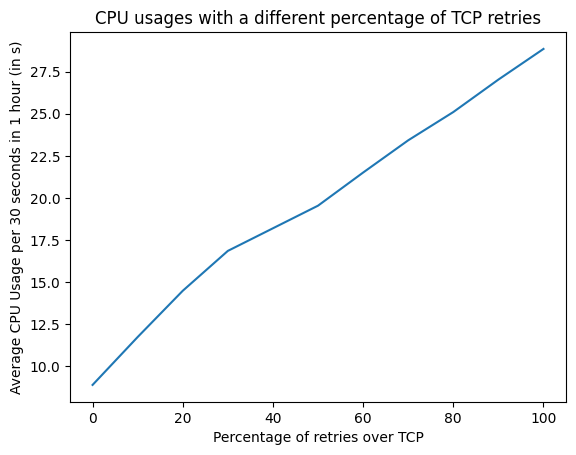

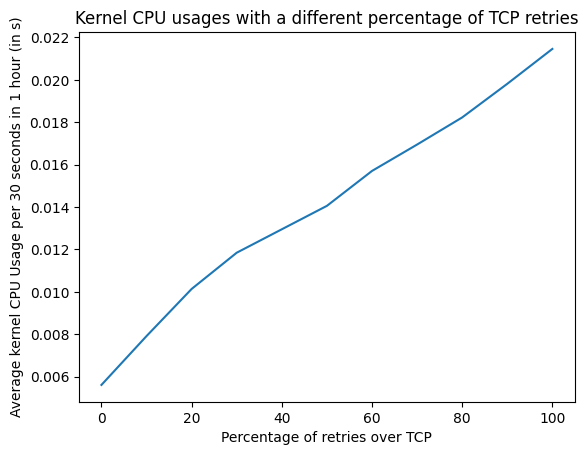

In [131]:
avgs_over_time = []
avgs_sys_over_time = []
percentages = [0, 10,20, 30, 50, 60, 70, 80, 90, 100]
for output in parsed_outputs:
    calc_avg_over_time(output, avgs_over_time, avgs_sys_over_time)

plt.plot(percentages, avgs_over_time)
plt.xlabel("Percentage of retries over TCP")
plt.ylabel("Average CPU Usage per 30 seconds in 1 hour (in s)")
plt.title("CPU usages with a different percentage of TCP retries")
plt.show()

plt.plot(percentages, avgs_sys_over_time)
plt.xlabel("Percentage of retries over TCP")
plt.ylabel("Average kernel CPU Usage per 30 seconds in 1 hour (in s)")
plt.title("Kernel CPU usages with a different percentage of TCP retries")
plt.show()

# Checking to see if there is any measurement that is significantly different

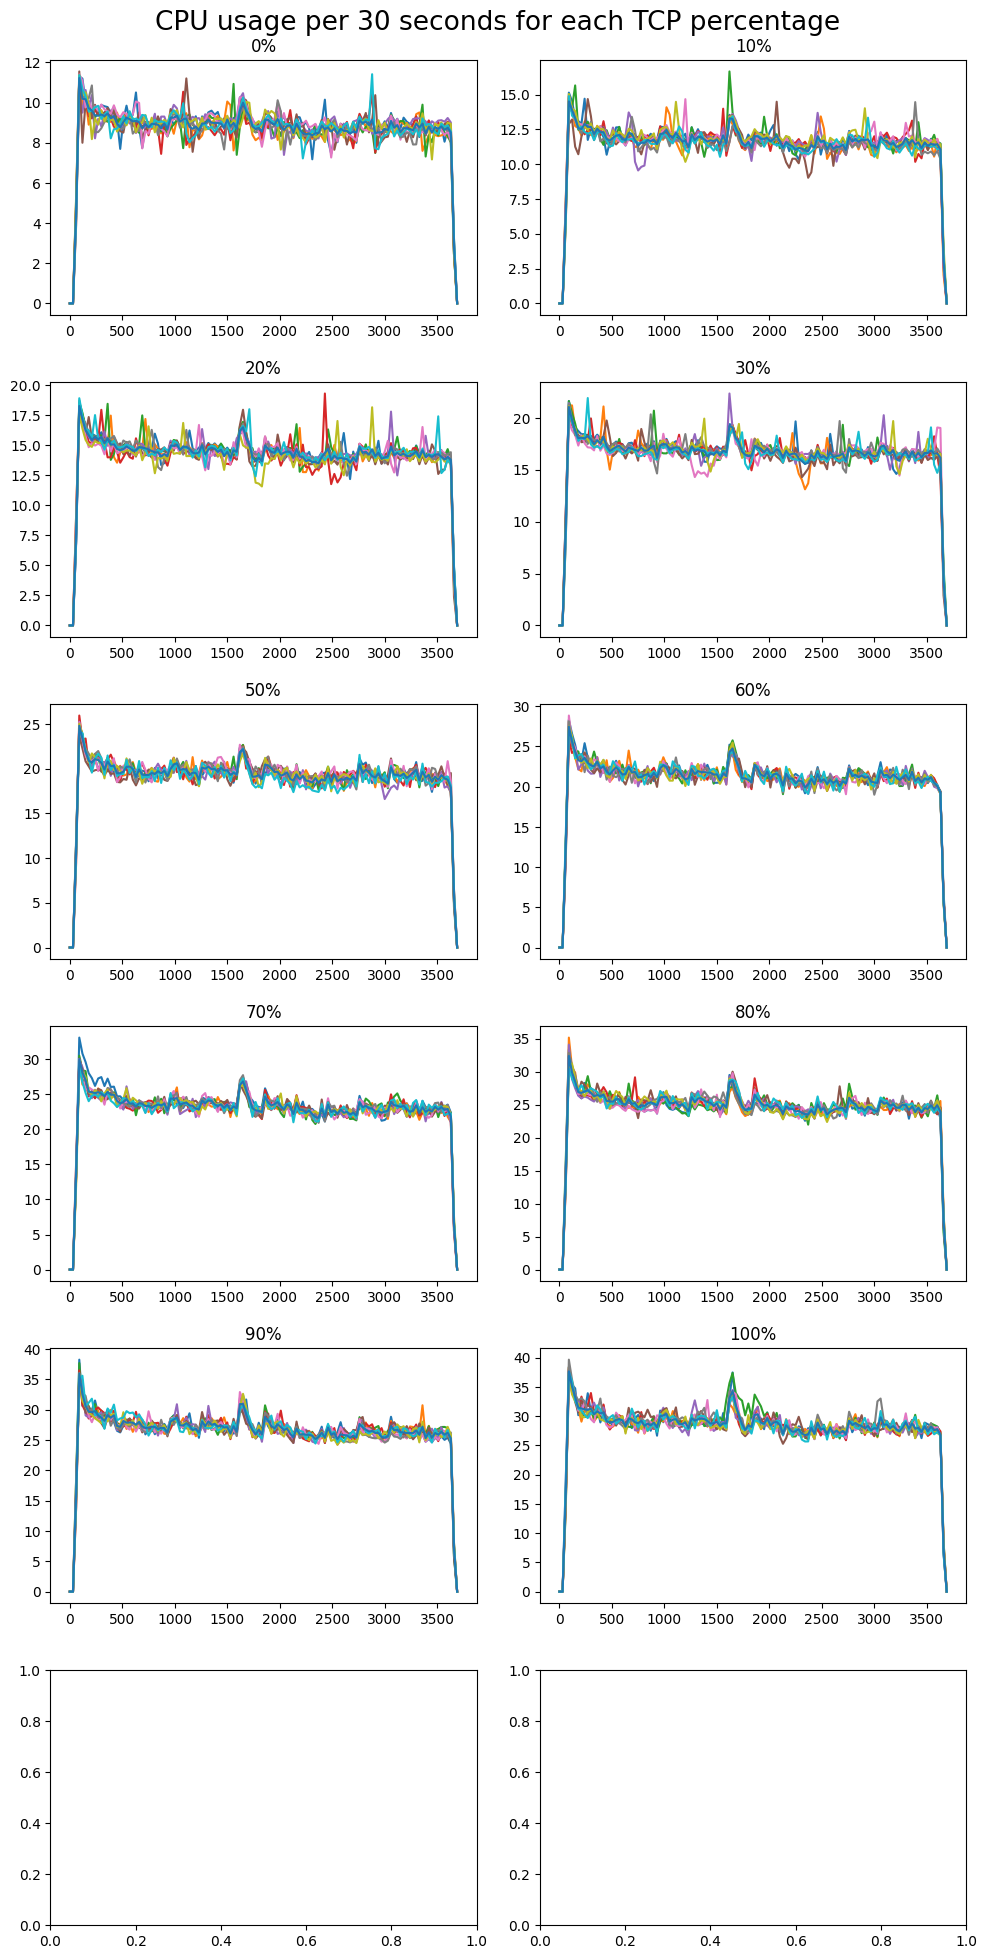

In [133]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))  
axs = axs.flatten()

i = 0
for line in to_plot_cpu:
    if line[2] is not None:
        axs[i].set_title(line[2].removeprefix("Avg for TCP "))
        axs[i].plot(line[0], line[1])
        i += 1
    else:
        axs[i].plot(line[0], line[1])
fig.suptitle('CPU usage per 30 seconds for each TCP percentage', fontsize=19)
plt.tight_layout(pad=1.5)
plt.show()  

## Get number of queries per 30 seconds

In [169]:
import csv
number_of_queries = []
with open('test-csv/n1-1h-anon.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    i = 2
    number_of_queries.append(0)
    number_of_queries.append(0) # The first 60 seconds no queries are being sent
    number_of_queries.append(0) # To start with for the 0 seconds
    next_value = 30000
    for row in spamreader:
        if int(row[0]) >= next_value:
            number_of_queries.append(0)
            i += 1
            next_value += 30000

        number_of_queries[i] += 1
    number_of_queries.append(0) 
    number_of_queries.append(0) # The last 60 seconds no queries are being sent

    # number_of_queries.append(0)
print(number_of_queries)

[0, 0, 239888, 210167, 200907, 178446, 186379, 176228, 182530, 176253, 175045, 173104, 182207, 171948, 174998, 161058, 167872, 166088, 173051, 163837, 166096, 156984, 175128, 159015, 165570, 158401, 165840, 158768, 166394, 160480, 163680, 157362, 182215, 170404, 173087, 162502, 170528, 161043, 166037, 160595, 160324, 155289, 176145, 164549, 174367, 166665, 168453, 161708, 166497, 160585, 163897, 155177, 167493, 156495, 211525, 185744, 174958, 163871, 158835, 155474, 159906, 151757, 184994, 165970, 163809, 161691, 168278, 156894, 164323, 160615, 157852, 150765, 164523, 153170, 159925, 150521, 157294, 148055, 152033, 150499, 159468, 151034, 165441, 155737, 153789, 150132, 158977, 151825, 155974, 150040, 157284, 152369, 174635, 159435, 164142, 159202, 160405, 154741, 161443, 152267, 154560, 156100, 171389, 160905, 165780, 157899, 161544, 156623, 159081, 159780, 161276, 153819, 165204, 150513, 158555, 152797, 159322, 155097, 160706, 155141, 157351, 151207, 0, 0]


In [170]:
print(len(number_of_queries))
print(to_plot_percentage_cpu_avg[0][0])

124
[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890, 1920, 1950, 1980, 2010, 2040, 2070, 2100, 2130, 2160, 2190, 2220, 2250, 2280, 2310, 2340, 2370, 2400, 2430, 2460, 2490, 2520, 2550, 2580, 2610, 2640, 2670, 2700, 2730, 2760, 2790, 2820, 2850, 2880, 2910, 2940, 2970, 3000, 3030, 3060, 3090, 3120, 3150, 3180, 3210, 3240, 3270, 3300, 3330, 3360, 3390, 3420, 3450, 3480, 3510, 3540, 3570, 3600, 3630, 3660, 3690]


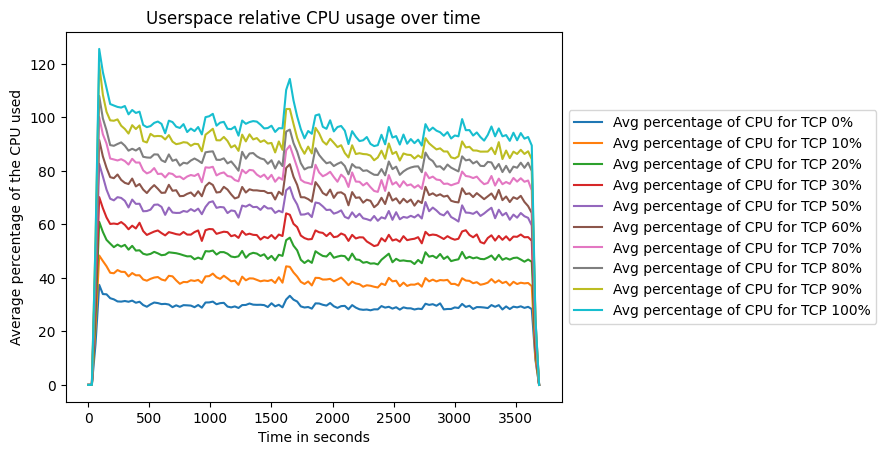

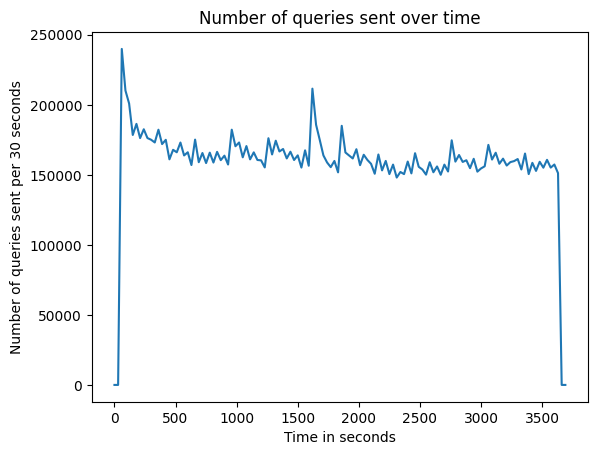

In [172]:
make_a_plot(to_plot_percentage_cpu_avg, "Time in seconds", "Average percentage of the CPU used", "Userspace relative CPU usage over time")
initial_time = 0
timing = to_plot_percentage_cpu_avg[0][0]

plt.plot(timing, number_of_queries)
plt.xlabel("Time in seconds")
plt.ylabel("Number of queries sent per 30 seconds")
plt.title("Number of queries sent over time")
plt.show()